# 🛑 Traffic Sign Recognition with CNN

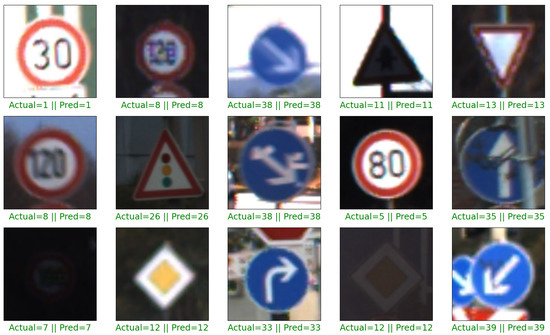

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.utils import shuffle
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import kagglehub

path = kagglehub.dataset_download("valentynsichkar/traffic-signs-preprocessed")

print("Path to dataset files:", path)


100%|██████████| 4.16G/4.16G [00:45<00:00, 98.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2


In [ ]:
print("Files in dataset folder:")
print(os.listdir(path))


Files in dataset folder:
['data8.pickle', 'data3.pickle', 'std_rgb.pickle', 'datasets_preparing.py', 'data0.pickle', 'data2.pickle', 'mean_image_rgb.pickle', 'data7.pickle', 'train.pickle', 'test.pickle', 'label_names.csv', 'data5.pickle', 'std_gray.pickle', 'data4.pickle', 'data1.pickle', 'labels.pickle', 'valid.pickle', 'mean_image_gray.pickle', 'data6.pickle']


In [ ]:

dataset_path = path


train_path = os.path.join(dataset_path, "train.pickle")
valid_path = os.path.join(dataset_path, "valid.pickle")
test_path  = os.path.join(dataset_path, "test.pickle")

In [ ]:
import pickle

# train
with open(train_path, 'rb') as f:
    train_data = pickle.load(f, encoding='latin1')
X_train, y_train = train_data['features'], train_data['labels']

# validation
with open(valid_path, 'rb') as f:
    valid_data = pickle.load(f, encoding='latin1')
X_valid, y_valid = valid_data['features'], valid_data['labels']

# test
with open(test_path, 'rb') as f:
    test_data = pickle.load(f, encoding='latin1')
X_test, y_test = test_data['features'], test_data['labels']

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (34799, 32, 32, 3) (34799,)
Valid: (4410, 32, 32, 3) (4410,)
Test: (12630, 32, 32, 3) (12630,)


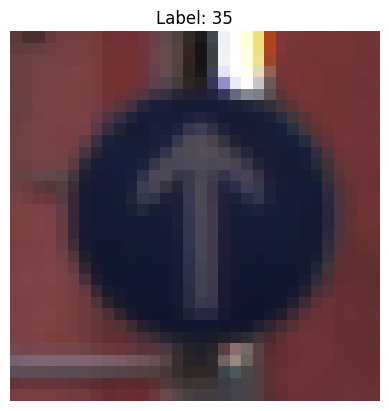

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

i = np.random.randint(0, len(X_train))
plt.imshow(X_train[i])
plt.title(f"Label: {y_train[i]}")
plt.axis("off")
plt.show()


In [ ]:
import pandas as pd

# Load label names file
labels = pd.read_csv(path + "/label_names.csv")

# Show the first rows
print("First 5 rows in label_names.csv:")
print(labels.head())

# Print number of classes
print("\nNumber of classes:", labels.shape[0])

# Print all class IDs with their names
print("\nAll traffic sign classes:")
for i, name in enumerate(labels['SignName']):
    print(f"{i}: {name}")



First 5 rows in label_names.csv:
   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

Number of classes: 43

All traffic sign classes:
0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing for vehicles over 3.5 metric tons
11: Right-of-way at the next intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Vehicles over 3.5 metric tons prohibited
17: No entry
18: General caution
19: Dangerous curve to the left
20: Dangerous curve to the right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/s

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical

# --- Resize images to a fixed size (e.g., 32x32) ---
IMG_SIZE = 32

def resize_images(images, img_size=IMG_SIZE):
    resized = []
    for img in images:
        img = cv2.resize(img, (img_size, img_size))
        resized.append(img)
    return np.array(resized)

X_train = resize_images(X_train, IMG_SIZE)
X_valid = resize_images(X_valid, IMG_SIZE)
X_test  = resize_images(X_test, IMG_SIZE)

print("Shapes after resizing:")
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test :", X_test.shape)

# --- Normalize pixel values (0-255 → 0-1) ---
X_train = X_train.astype("float32") / 255.0
X_valid = X_valid.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# --- One-hot encode the labels ---
num_classes = len(np.unique(y_train))  # should be 43 classes
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test  = to_categorical(y_test, num_classes)

print("\nLabels after one-hot encoding:")
print("y_train:", y_train.shape)
print("y_valid:", y_valid.shape)
print("y_test :", y_test.shape)


Shapes after resizing:
X_train: (34799, 32, 32, 3)
X_valid: (4410, 32, 32, 3)
X_test : (12630, 32, 32, 3)

Labels after one-hot encoding:
y_train: (34799, 43)
y_valid: (4410, 43)
y_test : (12630, 43)


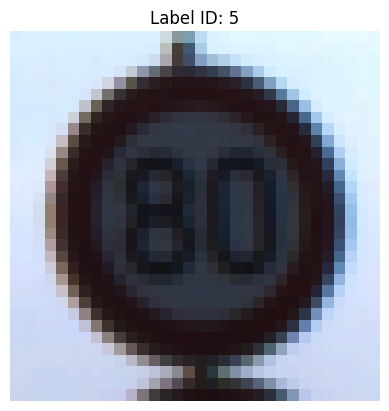

In [ ]:
import matplotlib.pyplot as plt

# Pick a random sample
i = np.random.randint(0, len(X_train))

plt.imshow(X_train[i])
plt.title(f"Label ID: {np.argmax(y_train[i])}")
plt.axis("off")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),


    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(43, activation='softmax')  # 43 classes
])

In [ ]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=30,
    verbose=1
)


Epoch 1/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.1685 - loss: 3.0972 - val_accuracy: 0.5587 - val_loss: 1.4698
Epoch 2/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5616 - loss: 1.3494 - val_accuracy: 0.8311 - val_loss: 0.6087
Epoch 3/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7824 - loss: 0.6751 - val_accuracy: 0.9079 - val_loss: 0.3465
Epoch 4/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8643 - loss: 0.4198 - val_accuracy: 0.9351 - val_loss: 0.2453
Epoch 5/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9036 - loss: 0.2972 - val_accuracy: 0.9637 - val_loss: 0.1806
Epoch 6/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9246 - loss: 0.2337 - val_accuracy: 0.9653 - val_loss: 0.1977
Epoch 7/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9387 - loss: 0.1926 - val_accuracy: 0.9703 - val_loss: 0.1227
Epoch 8/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9458 - loss: 0.1750 - val_accuracy: 0

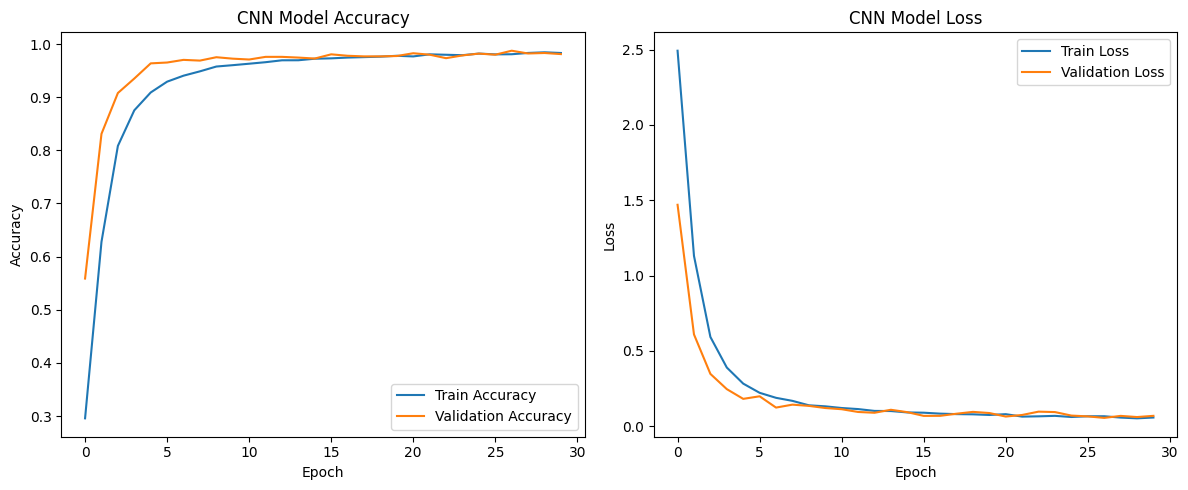

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9646
Test Loss: 0.1792


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


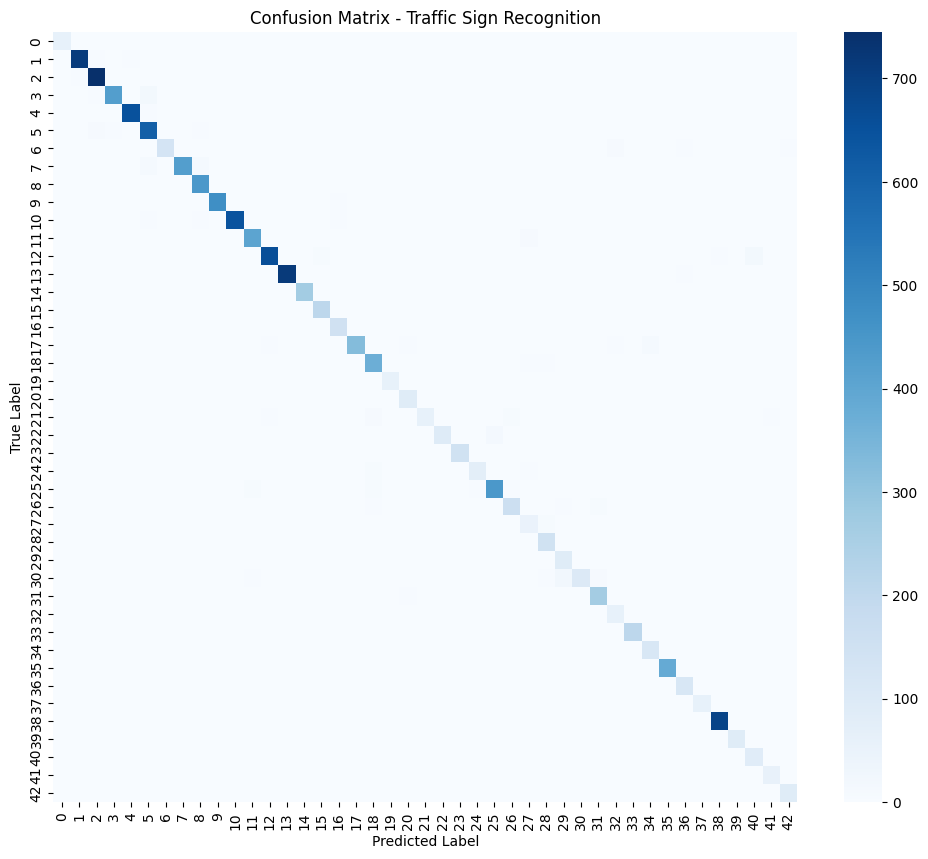

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      0.99      0.99       720
           2       0.97      0.99      0.98       750
           3       0.97      0.94      0.96       450
           4       0.99      0.98      0.99       660
           5       0.93      0.97      0.95       630
           6       0.98      0.87      0.92       150
           7       0.99      0.95      0.97       450
           8       0.95      0.98      0.97       450
           9       1.00      0.99      0.99       480
          10       1.00      0.98      0.99       660
          11       0.97      0.97      0.97       420
          12       0.99      0.95      0.97       690
          13       1.00      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.98       210
          16       0.94      1.00      0.97       150
          17       1.00    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)   # predicted labels
y_true = np.argmax(y_test, axis=1)           # true labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Traffic Sign Recognition")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# detailed classification report
print(classification_report(y_true, y_pred_classes))


In [ ]:
X_train[900].shape

(32, 32, 3)

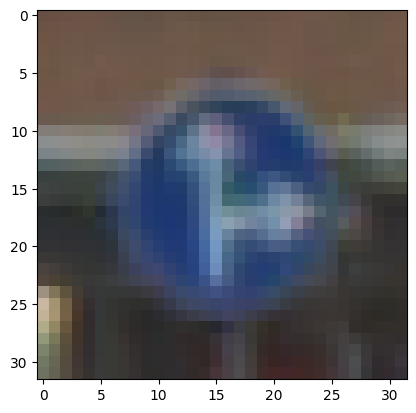

In [ ]:
plt.imshow(X_train[900])

In [ ]:
import numpy as np

# Take one image
img = X_train[900]

# Add extra dimension to make it a batch of size 1
img_batch = np.expand_dims(img, axis=0)

# Predict
prediction = model.predict(img_batch)
predicted_class = prediction.argmax()

print("Predicted class:", predicted_class)
print("True class:", np.argmax(y_train[900]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicted class: 36
True class: 36


# Data augmentation to improve performance

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


# 1) Normalize + Augmentation to training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

# validation/test only normalize
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 2) generators
batch_size = 64
train_generator = train_datagen.flow(X_train, to_categorical(y_train, num_classes=43), batch_size=batch_size)
valid_generator = valid_datagen.flow(X_valid, to_categorical(y_valid, num_classes=43), batch_size=batch_size)

# 3) Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),


    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(43, activation='softmax')  # 43 classes
])

# 4) Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5) Train
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator
)

# 6) Evaluate on test
test_generator = test_datagen.flow(X_test, to_categorical(y_test, num_classes=43), batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


Epoch 1/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.1023 - loss: 3.3600 - val_accuracy: 0.3878 - val_loss: 1.9358
Epoch 2/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.4010 - loss: 1.9149 - val_accuracy: 0.6422 - val_loss: 1.2029
Epoch 3/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.5585 - loss: 1.3404 - val_accuracy: 0.7385 - val_loss: 0.8331
Epoch 4/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.6596 - loss: 1.0261 - val_accuracy: 0.8193 - val_loss: 0.6144
Epoch 5/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.7220 - loss: 0.8264 - val_accuracy: 0.8553 - val_loss: 0.5054
Epoch 6/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.7667 - loss: 0.6988 - val_accuracy: 0.8964 - val_loss: 0.4150
Epoch 7/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.7963 - loss: 0.6161 - val_accuracy: 0.8952 - val_loss: 0.3929
Epoch 8/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.8191 - loss: 0